<a href="https://colab.research.google.com/github/cwattsnogueira/rating-predictor-spam-detection-review-summarizer/blob/main/08_01_02_HybridRatingPredictionPipelineBERT%2BEngineeredFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  Install dependencies
!pip install transformers datasets scikit-learn joblib --quiet

In [ ]:
#  Load libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

In [ ]:
#  Load dataset
df = pd.read_parquet("/content/engineered_features.parquet")
df = df[['clean_text', 'reviews.rating',
         'review_length', 'sentiment_polarity', 'repetition_score',
         'semantic_mismatch_score', 'product_name_match_flag',
         'unrelated_product_flag', 'username_dup_flag']].dropna()

In [ ]:
#  Prepare target
df['label'] = df['reviews.rating'].astype(int) - 1  # 0–4

In [ ]:
#  Normalize structured features
structured_cols = [
    'review_length', 'sentiment_polarity', 'repetition_score',
    'semantic_mismatch_score', 'product_name_match_flag',
    'unrelated_product_flag', 'username_dup_flag'
]
scaler = StandardScaler()
df[structured_cols] = scaler.fit_transform(df[structured_cols])

In [ ]:
#  Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#  Custom Dataset
class HybridReviewDataset(Dataset):
    def __init__(self, df):
        self.texts = df['clean_text'].tolist()
        self.features = df[structured_cols].values
        self.labels = df['label'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['features'] = torch.tensor(self.features[idx], dtype=torch.float)
        item['label'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

#  Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_dataset = HybridReviewDataset(train_df)
test_dataset = HybridReviewDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

#  Hybrid Model
class HybridBERTClassifier(nn.Module):
    def __init__(self, num_structured_features, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(768 + num_structured_features, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, features):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output  # [batch_size, 768]
        combined = torch.cat((pooled, features), dim=1)
        x = self.dropout(combined)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

#  Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridBERTClassifier(num_structured_features=len(structured_cols), num_classes=5)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

#  Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features = batch['features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask, features)
        loss = loss_fn(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 4: 100%|██████████| 474/474 [02:47<00:00,  2.82it/s, loss=0.222]


In [ ]:
#  Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features = batch['features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask, features)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

              precision    recall  f1-score   support

           0     0.5000    0.3778    0.4304        45
           1     0.0000    0.0000    0.0000        26
           2     0.2381    0.2353    0.2367        85
           3     0.4071    0.4259    0.4163       540
           4     0.7343    0.7417    0.7380      1200

    accuracy                         0.6102      1896
   macro avg     0.3759    0.3561    0.3643      1896
weighted avg     0.6032    0.6102    0.6065      1896



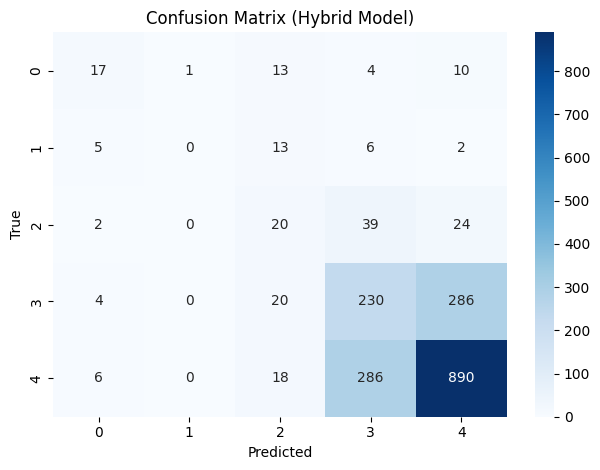

In [ ]:
#  Metrics
print(classification_report(all_labels, all_preds, digits=4))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Hybrid Model)")
plt.tight_layout()
plt.show()

In [ ]:
#  Save model weights
torch.save(model.state_dict(), "hybrid_rating_model.pt")

#  Save tokenizer (still BERT-based)
tokenizer.save_pretrained("hybrid_rating_model")

#  Save scaler for structured features
joblib.dump(scaler, "structured_feature_scaler.pkl")

from sklearn.metrics import classification_report, confusion_matrix

# Recompute metrics
report = classification_report(all_labels, all_preds, output_dict=True, digits=4)
cm = confusion_matrix(all_labels, all_preds)

#  Save evaluation metrics (if you already computed them)
joblib.dump({
    "classification_report": report,
    "confusion_matrix": cm.tolist()
}, "hybrid_rating_metrics.pkl")

['hybrid_rating_metrics.pkl']